# Getting started with Sentinel 2 data

As of mid-February 2018, Sentinel 2 data is available to access within the a development environment on AWS. There are a number of things that need to be done prior to gaining access to the Sentinel 2 archive. For the purpose of this notebook, we will assume you have successfully gained access to the AWS environment where Sentinel 2 data is currently housed. 

This notebook steps you through how to load in and plot up data from Sentinel 2.

This workflow is valid as of mid-February 2018.

In [1]:
% pylab notebook
from datacube import Datacube
from datetime import datetime
from skimage import exposure

# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/156/cek156/.aws_datacube.conf')

Populating the interactive namespace from numpy and matplotlib


## Define some plotting functions for later on

In [2]:
def threeBandImage(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    '''
    t, y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour][time].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

def threeBandImage_subplots(ds, bands, num_cols, figsize = [10,10], projection = 'projected', left  = 0.125, 
                            right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.4):
    '''
    threeBandImage_subplots takes three spectral bands and multiple time steps, and plots them 
    on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    num_cols - number of columns for the subplot
    
    Optional:
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    left  = 0.125  # the space on the left side of the subplots of the figure
    right = 0.9    # the space on the right side of the subplots of the figure
    bottom = 0.1   # the space on the bottom of the subplots of the figure
    top = 0.9      # the space on the top of the subplots of the figure
    wspace = 0.2   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    '''
    # Find the number of rows/columns we need, based on the number of time steps in ds
    timesteps = ds.time.size
    num_rows = int(ceil(timesteps/num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    fig.subplots_adjust(left  = left, right = right, bottom = bottom, top = top, wspace = wspace, hspace = hspace)
    numbers = 0
    try:
        for ax in axes.flat:
            t, y, x = ds[bands[0]].shape
            rawimg = np.zeros((y,x,3), dtype = np.float32)
            for i, colour in enumerate(bands):
                rawimg[:,:,i] = ds[colour][numbers].values
            rawimg[rawimg == -999] = np.nan
            img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
            ax.imshow(img_toshow)
            ax.set_title(str(ds.time[numbers].values), fontweight = 'bold', fontsize = 12)
            ax.set_xticklabels(ds.x.values)
            ax.set_yticklabels(ds.y.values)
            if projection == 'geographic':
                ax.set_xlabel('Longitude', fontweight = 'bold')
                ax.set_ylabel('Latitude', fontweight = 'bold')
            else:
                ax.set_xlabel('Eastings', fontweight = 'bold')
                ax.set_ylabel('Northings', fontweight = 'bold')
            numbers = numbers + 1
    except IndexError:
        # This error will pop up if there are not enough scenes to fill the number of rows x columns
        pass    

# Let's see what Sentinel 2 products are available

In [3]:
products = s2aws.list_products()
display_columns = ['name', 'description', 'instrument', 'platform', 'product_type', 'crs', 'resolution']
sentinel_products = products[products['instrument'] == 'MSI'][display_columns]
sentinel_products

name                                        description  \
id                                                                           
79      s2a_ard_granule  Sentinel-2A MSI ARD - NBAR NBART and Pixel Qua...   
69  s2a_level1c_granule  Sentinel-2A Level1C - Ortho Rectified Top of A...   
71  s2a_sen2cor_granule  Sentinel-2 Level 2 - Sen2Cor Bottom of Atmosph...   
81      s2b_ard_granule  Sentinel-2B MSI ARD - NBAR NBART and Pixel Qua...   
70  s2b_level1c_granule  Sentinel-2B Level1C - Ortho Rectified Top of A...   

   instrument     platform product_type  crs resolution  
id                                                       
79        MSI  Sentinel-2A     S2MSIARD  NaN        NaN  
69        MSI  Sentinel-2A      S2MSI1C  NaN        NaN  
71        MSI  SENTINEL_2A     S2MSI2Ap  NaN        NaN  
81        MSI  Sentinel-2B     S2MSIARD  NaN        NaN  
70        MSI  Sentinel-2B      S2MSI1C  NaN        NaN

# Now we want to actually load and look at some data

To load in the Sentinel data, we have a number of options we can use in building our data extraction query:

* `lat`/`lon` - specify a bounding box for the extraction. Note that a polygon can be used instead. See [here](https://datacube-core.readthedocs.io/en/stable/dev/generate/datacube.api.query.Query.html#datacube.api.query.Query) for more details
* `output_crs` - the output coordinate reference system to project the data into. The CRS you request will impact on the format for the `resolution` query. Two handy CRSs are 'EPSG:3577', which is the Australian Albers projected coordinate system, and 'EPSG:4325', which is WGS84 a global geographic coordinate system.
* `resolution` - the requested output resolution for the data. If you have selected a geographic coordinate system for the `output_crs`, this will be in degrees. If you have selected a projected coordinate system, this will be in metres. 
* `time` - the time range for the query.

In [4]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-01-01', '2017-02-15')
        }

Canberra = s2aws.load(product='s2a_ard_granule', **query)

## See what came back from the extraction

In [5]:
Canberra

<xarray.Dataset>
Dimensions:        (time: 4, x: 1229, y: 1248)
Coordinates:
  * time           (time) datetime64[ns] 2017-01-05T00:02:12.026000 ...
  * y              (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x              (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    pixel_quality  (time, y, x) uint8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 ...
    contiguity     (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    aerosol        (time, y, x) int16 886 886 886 886 886 931 931 931 931 ...
    blue           (time, y, x) int16 777 703 714 732 814 782 752 773 690 ...
    green          (time, y, x) int16 904 839 843 865 910 877 837 816 739 ...
    red            (time, y, x) int16 987 843 858 828 963 907 822 892 795 ...
    rededge1       (time, y, x) int16 1291 1303 1303 1282 1282 1221 1221 ...
    rededge2       (time, y, x) int16 1975 1931 1931 1945 1945 1887 1887 ...
    rededge3       (time, y, x) int16 2336 2346 2346 23

# About Sentinel 2 bands
Sentinel 2 satellites have 13 spectral channels:

| Sentinel 2 bands | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | 1 | 443 | 60 | 20 |
| Blue | 2 | 490 | 10 | 65 |
| Green | 3 | 560 | 10 | 35 |
| Red | 4 | 665 | 10 | 30 |
| Vegetation red edge | 5 | 705 | 20 | 15 |
| Vegetation red edge | 6 | 740 | 20 | 15 |
| Vegetation red edge | 7 | 783 | 20 | 20 |
| NIR | 8 | 842 | 10 | 115 |
| Narrow NIR | 8A | 865 | 20 | 20 |
| Water vapour | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | 10 | 1375 | 60 | 20 |
| SWIR | 11 | 1610 | 20 | 90 |
| SWIR | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths

![Sentinel 2 bands](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

## Data corrections

There are two corrections applied to the Sentinel data:

1. **NBAR (e.g. `green`)**  
NBAR stands for Nadir-corrected BRDF Adjusted Reflectance, where BRDF stands for Bidirectional reflectance distribution function The approach involves atmospheric correction to compute surface-leaving radiance, and bi-directional reflectance modelling to remove the effects of topography and angular variation in reflectance.

2. **T_NBAR (e.g. `t_green`)**  
Surface reflectance T_NBAR includes the terrain illumination reflectance correction and has the same features of NBAR, along with some additional features.

For more information on these corrections, see the explanation of the [Landsat archive data](http://geoscienceaustralia.github.io/digitalearthau/data/data.html#). 

# Plot this scene up as true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

<IPython.core.display.Javascript object>


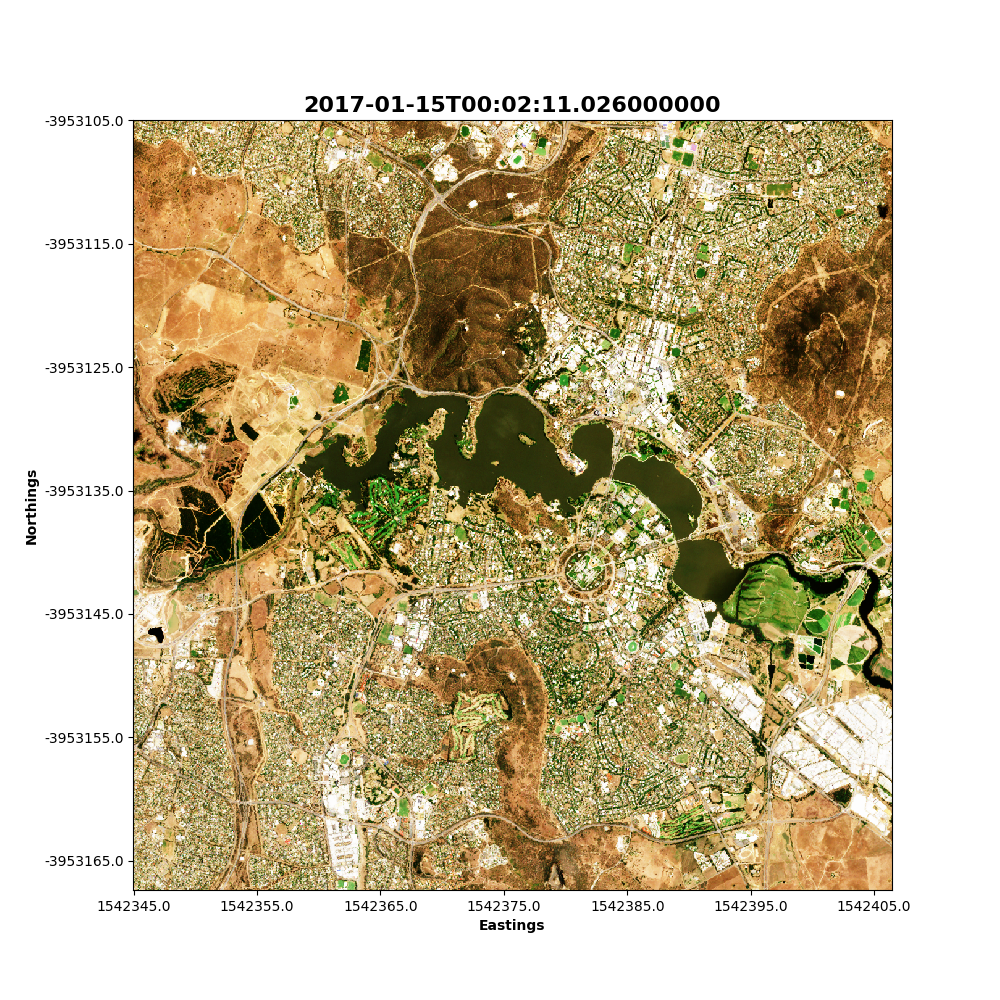

In [6]:
threeBandImage(Canberra, bands = ['red', 'green', 'blue'], time = 1)

# Plot this scene up as false colour image

This plot uses the SWIR, NIR and green bands to accentuate the presence of water in the landscape.

<IPython.core.display.Javascript object>


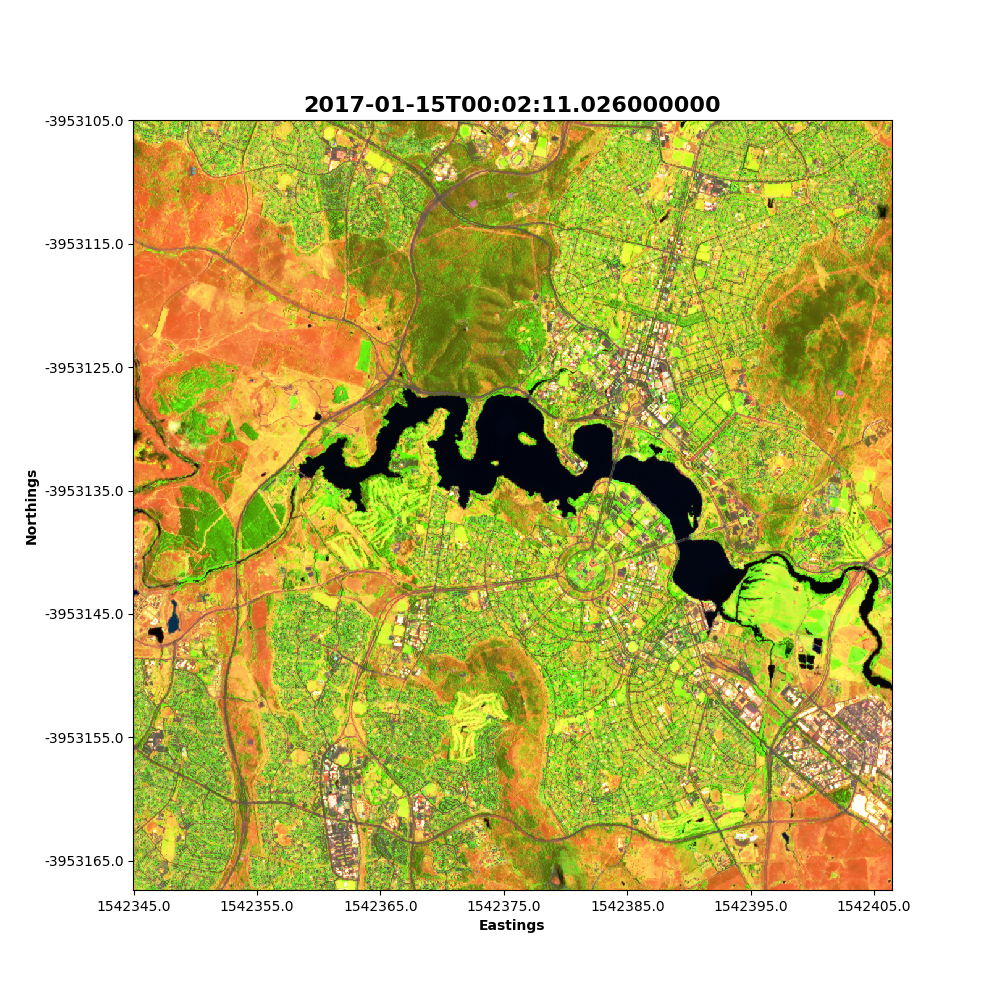

In [7]:
threeBandImage(Canberra, bands = ['swir1','nir','green'], time = 1)

# Compare some scenes side-by-side

<IPython.core.display.Javascript object>


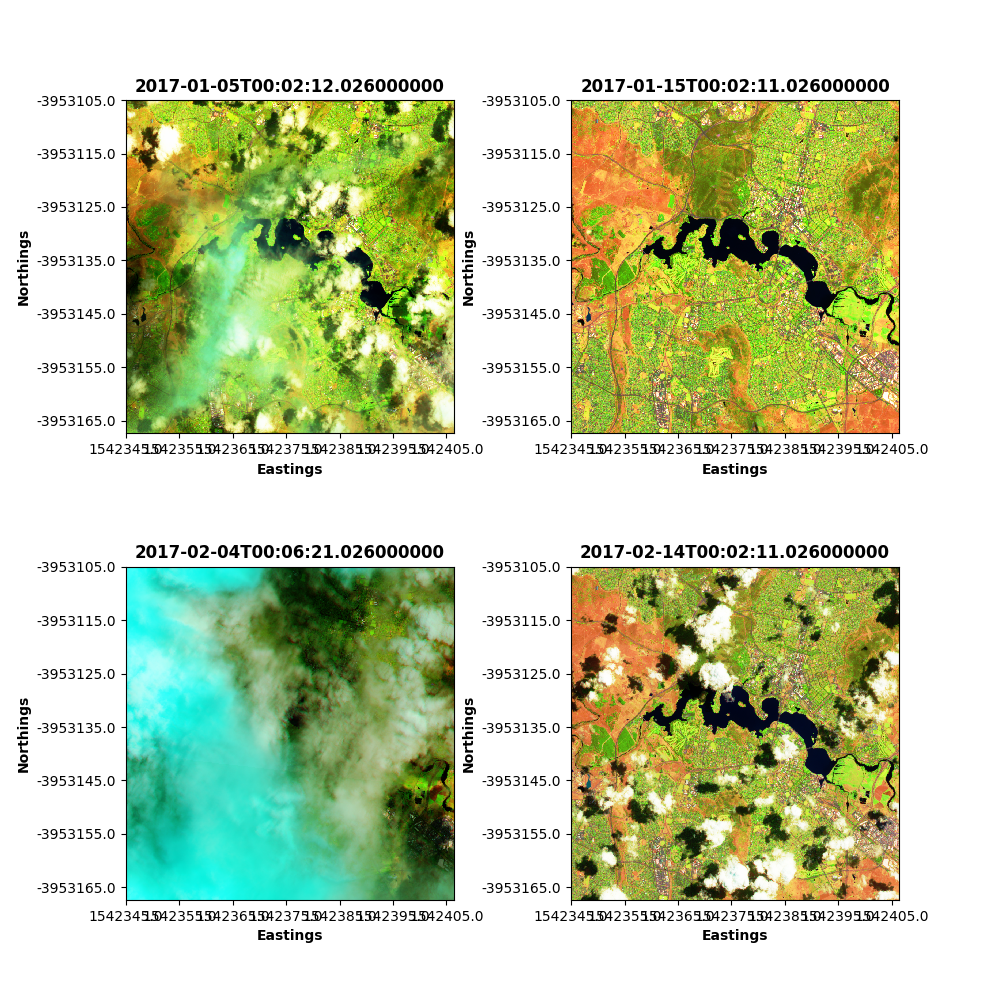

In [8]:
threeBandImage_subplots(Canberra, bands = ['swir1','nir','green'], num_cols = 2, figsize = [10, 10], wspace = 0.35)